In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.autograd import Variable
from PIL import Image
from random import choices

from tqdm import tqdm_notebook

from IPython.display import clear_output

Device init

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Weights init

In [0]:
def InitWeights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Main VAE architecture

In [0]:
class VAE(nn.Module):
    def __init__(self, dimZ=64, hidden_layer_dim=128):
        super(VAE, self).__init__()
        
        self.gru_enc = nn.GRU(128, hidden_layer_dim, 1, batch_first=True)
        
        self.fc_enc_1 = nn.Linear(hidden_layer_dim, dimZ)
        self.fc_enc_2 = nn.Linear(hidden_layer_dim, dimZ)
        
        self.fc_dec_1 = nn.Linear(dimZ, hidden_layer_dim)
        
        self.gru_cell_dec = nn.GRUCell(128, hidden_layer_dim)
        
        self.fc_dec_hidd_to_pitch = nn.Linear(hidden_layer_dim, 128)
        
    
    def encode(self, seq):
        h = F.relu(self.gru_enc(seq)[1][0])
        return self.fc_enc_1(h), self.fc_enc_2(h)
        
    def decode(self, z, length):
        h = F.relu(self.fc_dec_1(z))
        current_pitch = F.softmax(self.fc_dec_hidd_to_pitch(h), dim=1)
        
        seq = []
        for num_iter in range(length):
            seq.append(current_pitch)
            
            h = self.gru_cell_dec(current_pitch, h)
            current_pitch = F.softmax(self.fc_dec_hidd_to_pitch(h), dim=1)
            
        return torch.stack(seq, dim=1)
          
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = logsigma.exp()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps * std + mu
        else:
            return mu

    def forward(self, x):
      
        length = x.shape[1]
      
        latent_mu, latent_logsigma = self.encode(x)
        z = self.gaussian_sampler(latent_mu, latent_logsigma)
        
        reconstruction = self.decode(z, length)
        return reconstruction, latent_mu, latent_logsigma

In [0]:
def KL_divergence(mu, logsigma):
    vector = 1 + 2 * logsigma - mu ** 2 - torch.exp(2 * logsigma)
    return -0.5 * vector.sum(dim=1).mean()

Starting the training

In [6]:
!wget https://storage.googleapis.com/magentadata/datasets/maestro/v1.0.0/maestro-v1.0.0-midi.zip
!unzip maestro-v1.0.0-midi.zip

--2019-06-05 15:58:35--  https://storage.googleapis.com/magentadata/datasets/maestro/v1.0.0/maestro-v1.0.0-midi.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.70.128, 2607:f8b0:4001:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.70.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46579421 (44M) [application/zip]
Saving to: ‘maestro-v1.0.0-midi.zip’

maestro-v1.0.0-midi 100%[===================>]  44.42M  91.2MB/s    in 0.5s    

2019-06-05 15:58:35 (91.2 MB/s) - ‘maestro-v1.0.0-midi.zip’ saved [46579421/46579421]

Archive:  maestro-v1.0.0-midi.zip
   creating: maestro-v1.0.0/
  inflating: maestro-v1.0.0/LICENSE  
  inflating: maestro-v1.0.0/maestro-v1.0.0.csv  
   creating: maestro-v1.0.0/2017/
  inflating: maestro-v1.0.0/2017/MIDI-Unprocessed_045_PIANO045_MID--AUDIO-split_07-06-17_Piano-e_2-01_wav--2.midi  
  inflating: maestro-v1.0.0/2017/MIDI-Unprocessed_059_PIANO059_MID--AUDIO-split_07-07-17_Piano-e

In [0]:
import glob
import random
import pretty_midi
import IPython
import numpy as np
from tqdm import tnrange, tqdm_notebook, tqdm
from random import shuffle, seed
import numpy as np
import numpy as np
from numpy.random import choice
import pickle
import matplotlib.pyplot as plt

import unicodedata
import re
import numpy as np
import os
import io
import time

In [0]:
def get_list_midi(folder = 'maestro-v1.0.0/**/*.midi', seed_int = 666):
    """Get the list of all midi file in the folders

    Parameters
    ==========
    folder : str
    The midi folder.
    seed_int : int
    the random seed.

    Returns
    =======
    The midi files

    """
    list_all_midi = glob.glob(folder)
    seed(seed_int)
    shuffle(list_all_midi)
    return list_all_midi

list_all_midi = get_list_midi()

In [0]:
def generate_dict_time_notes(list_all_midi, batch_song = 16, start_index=0, fs=30, use_tqdm=True):
    """ Generate map (dictionary) of music ( in index ) to piano_roll (in np.array)

    Parameters
    ==========
    list_all_midi : list
        List of midi files
    batch_music : int
      A number of music in one batch
    start_index : int
      The start index to be batched in list_all_midi
    fs : int
      Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    use_tqdm : bool
      Whether to use tqdm or not in the function

    Returns
    =======
    dictionary of music to piano_roll (in np.array)

    """
    assert len(list_all_midi) >= batch_song
    
    dict_time_notes = {}
    process_tqdm_midi = tqdm_notebook(range(start_index, min(start_index + batch_song, len(list_all_midi)))) if use_tqdm else range(start_index,  min(start_index + batch_song, len(list_all_midi)))
    for i in process_tqdm_midi:
        midi_file_name = list_all_midi[i]
        if use_tqdm:
            process_tqdm_midi.set_description("Processing {}".format(midi_file_name))
        try: # Handle exception on malformat MIDI files
            midi_pretty_format = pretty_midi.PrettyMIDI(midi_file_name)
            piano_midi = midi_pretty_format.instruments[0] # Get the piano channels
            piano_roll = piano_midi.get_piano_roll(fs=fs)
            dict_time_notes[i] = piano_roll
        except Exception as e:
            print(e)
            print("broken file : {}".format(midi_file_name))
            pass
    return dict_time_notes

In [10]:
dict_time_notes = generate_dict_time_notes(list_all_midi, batch_song = 16, start_index=0, fs=30, use_tqdm=True)

In [0]:
def generate_training_data(list_all_midi, batch_song = 16, train_size = 50, target_size = 1, 
                           start_index=0, fs=30, use_tqdm=True, ignore_velocity = True):
    """
    Generate traning batch of training data.
    Data is a sequence of notes in piano-roll representation
    
    Parameters
    ==========
    list_all_midi : list
      List of midi files
    batch_music : int
      A number of music in one batch
    train_size : int
      A number of notes used for prediction
    target_size : int
      A number of notes to be predicted
    start_index : int
      The start index to be batched in list_all_midi
    fs : int
      Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    seq_len : int
      The sequence length of the music to be input of neural network
    use_tqdm : bool
      Whether to use tqdm or not in the function
    ignore_velocity : bool
      Whether to use real valued or binary representation of note's velocity
    
    Returns
    =======
    Tuple of input and target neural network
    """
    
    dict_time_notes = generate_dict_time_notes(list_all_midi, batch_song, start_index, fs, use_tqdm)
    
    list_data, list_target = [], []
    for _, value in dict_time_notes.items():
        for i in range(0, value.shape[1], train_size + target_size):
            sample = value[:, i: i + train_size + target_size]
            if ignore_velocity:
                sample = np.where(sample > 0, 1, sample)
            if sample.shape[1] == train_size + target_size:
                list_data.append(sample[:, :train_size].T)
                list_target.append(sample[:, train_size:].T)
    
    return np.array(list_data), np.array(list_target)

In [12]:
list_data, list_target = generate_training_data(list_all_midi)

In [13]:
list_target[123, 0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
def generate_batch_song(list_all_midi, batch_music=16, start_index=0, fs=30, seq_len=50, use_tqdm=False):
    """
    Generate Batch music that will be used to be input and output of the neural network
    
    Parameters
    ==========
    list_all_midi : list
      List of midi files
    batch_music : int
      A number of music in one batch
    start_index : int
      The start index to be batched in list_all_midi
    fs : int
      Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    seq_len : int
      The sequence length of the music to be input of neural network
    use_tqdm : bool
      Whether to use tqdm or not in the function
    
    Returns
    =======
    Tuple of input and target neural network
    
    """
    
    assert len(list_all_midi) >= batch_music
    dict_time_notes = generate_dict_time_notes(list_all_midi, batch_music, start_index, fs, use_tqdm=use_tqdm)
    
    list_musics = process_notes_in_song(dict_time_notes, seq_len)
    collected_list_input, collected_list_target = [], []
     
    for music in list_musics:
        list_training, list_target = generate_input_and_target(music, seq_len)
        collected_list_input += list_training
        collected_list_target += list_target
    return collected_list_input, collected_list_target

In [0]:
from IPython import display

class TrainModel:
  
    def __init__(self, epochs, sampled_midi, frame_per_second, 
               batch_nnet_size, batch_song, optimizer, loss_fn, total_songs, model, seq_len):
        self.epochs = epochs
        self.sampled_midi = sampled_midi
        self.frame_per_second = frame_per_second
        self.batch_nnet_size = batch_nnet_size
        self.batch_song = batch_song
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.total_songs = total_songs
        self.model = model
        self.seq_len = seq_len
        self.train_loss_history = []
        self.val_loss_history = []
    
    def train(self):
        loss_history = []
      
      
        for epoch in tqdm_notebook(range(self.epochs), desc='epochs'):
            # for each epochs, we shufle the list of all the datasets
            shuffle(self.sampled_midi)
            
            train_val_separator_index = int(0.9 * len(self.sampled_midi))
            train_data = self.sampled_midi[:train_val_separator_index]
            val_data = self.sampled_midi[train_val_separator_index:]
            
            loss_total = 0
            train_loss_history = []
            val_loss_history = []
            
            steps = 0
            steps_nnet = 0

            # We will iterate all songs by self.song_size
            for i in tqdm_notebook(range(0, len(train_data), self.batch_song), desc='MUSIC'):

                steps += 1
                
                inputs_train, outputs_train = generate_training_data(train_data, self.batch_song, 
                                                                     train_size = seq_len, target_size = 1, 
                                                                     start_index=i, use_tqdm=False)
                
                inputs_val, outputs_val = generate_training_data(val_data, len(val_data),
                                                                 train_size = seq_len, target_size = 1,
                                                                 start_index=i, use_tqdm=False)
                
                inputs_tensor_val = torch.tensor(inputs_val, dtype=torch.float)
                outputs_tensor_val = torch.tensor(outputs_val, dtype=torch.float)

                index_shuffled = np.arange(start=0, stop=len(inputs_train))
                np.random.shuffle(index_shuffled)

                for nnet_steps in tqdm_notebook(range(0,len(index_shuffled), self.batch_nnet_size)):
        
                    steps_nnet += 1
                    current_index = index_shuffled[nnet_steps:nnet_steps+self.batch_nnet_size]
                    inputs, outputs = inputs_train[current_index], outputs_train[current_index]

                    inputs_tensor_train = torch.tensor(inputs, dtype=torch.float).cuda()
                    outputs_tensor_train = torch.tensor(outputs, dtype=torch.float32).cuda()

                    


#                     if len(inputs) // self.batch_nnet_size != 1:
#                         break
                        
                    self.model.train()
                    
                    reconstr, mu, logsigma = self.model.forward(inputs_tensor_train)
                    loss = self.loss_fn(inputs_tensor_train, reconstr, mu, logsigma)
                    loss.backward()
                    self.optimizer.step()
                    self.optimizer.zero_grad()
                    loss_total += loss
                    
                    n_verbose = 20
                    if steps_nnet % n_verbose == 0:
                        loss_mean = (loss_total / n_verbose).detach().cpu().numpy()
                        print("epochs {} | Steps {} | total loss : {}".format(epoch + 1, steps_nnet, loss_mean))
                        self.train_loss_history.append(loss_mean)
                        loss_total = 0
                        
#                         val_prediction, _ = self.model.forward(inputs_tensor_val)#, self.seq_len)
#                         val_loss = self.loss_fn(prediction_val, outputs_tensor_val).detach().cpu().numpy()
#                         print(f'val loss: {val_loss}')
#                         self.val_loss_history.append(val_loss)
                        
                    self.model.eval()


In [0]:
learning_rate = 0.001
seq_len = 20
EPOCHS = 50
BATCH_SONG = 16
BATCH_NNET_SIZE = 512
TOTAL_SONGS = len(list_all_midi)
FRAME_PER_SECOND = 20

def loss_vae(targets, prediction, mu_z, logsigma_z):
  
    n_notes = targets.sum(dim=2, keepdim=True)
    n_notes[n_notes == 0] = 1.0
  
    freqs = targets / n_notes
     
    return 0.1 * KL_divergence(mu_z, logsigma_z) - (torch.log(prediction) * freqs).sum(dim=2).mean()

In [0]:
test = VAE(64, 128)

In [0]:
reconstr, mu, logsigma = test(torch.tensor(list_data[:20], dtype=torch.float32))

In [0]:
loss_vae(torch.tensor(list_data[:20], dtype=torch.float32), reconstr, mu, logsigma)

tensor(3.8395, grad_fn=<SubBackward0>)

In [0]:
model = VAE(64, 128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [58]:
train_class = TrainModel(EPOCHS, list_all_midi[:100], FRAME_PER_SECOND,
                         BATCH_NNET_SIZE, BATCH_SONG, optimizer, loss_vae, TOTAL_SONGS, model, seq_len)
train_class.train()

epochs 1 | Steps 20 | total loss : 3.680136203765869


epochs 1 | Steps 40 | total loss : 3.42295241355896


epochs 1 | Steps 60 | total loss : 3.3485238552093506


epochs 1 | Steps 80 | total loss : 3.2621891498565674
epochs 1 | Steps 100 | total loss : 3.0982794761657715


epochs 1 | Steps 120 | total loss : 3.2780892848968506


epochs 2 | Steps 20 | total loss : 3.20982027053833


epochs 2 | Steps 40 | total loss : 3.2268714904785156


epochs 2 | Steps 60 | total loss : 3.225891590118408


epochs 2 | Steps 80 | total loss : 3.2286999225616455


epochs 2 | Steps 100 | total loss : 3.193324565887451
epochs 2 | Steps 120 | total loss : 3.3803184032440186


epochs 3 | Steps 20 | total loss : 3.152892827987671


epochs 3 | Steps 40 | total loss : 3.184677839279175


epochs 3 | Steps 60 | total loss : 3.225933074951172
epochs 3 | Steps 80 | total loss : 3.2213432788848877


epochs 3 | Steps 100 | total loss : 3.1359288692474365


epochs 3 | Steps 120 | total loss : 3.2935547828674316


epochs 4 | Steps 20 | total loss : 3.176494836807251


epochs 4 | Steps 40 | total loss : 3.2321267127990723


epochs 4 | Steps 60 | total loss : 3.2643284797668457


epochs 4 | Steps 80 | total loss : 3.225569486618042


epochs 4 | Steps 100 | total loss : 3.1838736534118652
epochs 4 | Steps 120 | total loss : 3.145355224609375


epochs 5 | Steps 20 | total loss : 3.203871488571167


epochs 5 | Steps 40 | total loss : 3.239940643310547


epochs 5 | Steps 60 | total loss : 3.203876256942749


epochs 5 | Steps 80 | total loss : 3.1689693927764893
epochs 5 | Steps 100 | total loss : 3.1310460567474365


epochs 5 | Steps 120 | total loss : 3.126655340194702


epochs 6 | Steps 20 | total loss : 3.169095039367676


epochs 6 | Steps 40 | total loss : 3.115208625793457


epochs 6 | Steps 60 | total loss : 3.120388984680176


epochs 6 | Steps 80 | total loss : 3.218968629837036


epochs 6 | Steps 100 | total loss : 3.152564764022827


epochs 6 | Steps 120 | total loss : 2.9715094566345215


epochs 7 | Steps 20 | total loss : 3.0567288398742676


epochs 7 | Steps 40 | total loss : 3.05672287940979


epochs 7 | Steps 60 | total loss : 3.0751230716705322


epochs 7 | Steps 80 | total loss : 3.118462324142456


epochs 7 | Steps 100 | total loss : 3.0618574619293213
epochs 7 | Steps 120 | total loss : 3.004983901977539


epochs 8 | Steps 20 | total loss : 3.177067279815674


epochs 8 | Steps 40 | total loss : 2.9909024238586426


epochs 8 | Steps 60 | total loss : 2.9671390056610107


epochs 8 | Steps 80 | total loss : 3.0163562297821045


epochs 8 | Steps 100 | total loss : 3.067384958267212


epochs 8 | Steps 120 | total loss : 3.0191547870635986


epochs 9 | Steps 20 | total loss : 3.066528081893921


epochs 9 | Steps 40 | total loss : 3.125890016555786


epochs 9 | Steps 60 | total loss : 3.051438093185425


epochs 9 | Steps 80 | total loss : 3.0221171379089355


epochs 9 | Steps 100 | total loss : 2.983158826828003
epochs 9 | Steps 120 | total loss : 2.956803560256958


epochs 10 | Steps 20 | total loss : 2.945772886276245


epochs 10 | Steps 40 | total loss : 2.958486795425415


epochs 10 | Steps 60 | total loss : 2.988222360610962


epochs 10 | Steps 80 | total loss : 2.986618757247925
epochs 10 | Steps 100 | total loss : 3.0408575534820557


epochs 10 | Steps 120 | total loss : 3.003096342086792


epochs 11 | Steps 20 | total loss : 2.978123426437378


epochs 11 | Steps 40 | total loss : 2.9971776008605957


epochs 11 | Steps 60 | total loss : 2.9569613933563232


epochs 11 | Steps 80 | total loss : 2.978971004486084


epochs 11 | Steps 100 | total loss : 2.9923055171966553


epochs 11 | Steps 120 | total loss : 2.94454026222229


epochs 12 | Steps 20 | total loss : 2.900099754333496


epochs 12 | Steps 40 | total loss : 2.9747817516326904


epochs 12 | Steps 60 | total loss : 2.9401776790618896


epochs 12 | Steps 80 | total loss : 2.979229688644409


epochs 12 | Steps 100 | total loss : 3.0007951259613037


epochs 12 | Steps 120 | total loss : 2.962078809738159


epochs 13 | Steps 20 | total loss : 2.9244701862335205


epochs 13 | Steps 40 | total loss : 2.9977171421051025


epochs 13 | Steps 60 | total loss : 2.9256107807159424
epochs 13 | Steps 80 | total loss : 2.8837947845458984


epochs 13 | Steps 100 | total loss : 2.926936149597168
epochs 13 | Steps 120 | total loss : 2.934887409210205


epochs 14 | Steps 20 | total loss : 2.8996493816375732
epochs 14 | Steps 40 | total loss : 2.9813592433929443


epochs 14 | Steps 60 | total loss : 2.863220691680908
epochs 14 | Steps 80 | total loss : 2.7927935123443604


epochs 14 | Steps 100 | total loss : 2.9034996032714844


epochs 14 | Steps 120 | total loss : 2.926790714263916


epochs 15 | Steps 20 | total loss : 2.9192965030670166


epochs 15 | Steps 40 | total loss : 2.8848459720611572


epochs 15 | Steps 60 | total loss : 2.933594226837158


epochs 15 | Steps 80 | total loss : 2.839919090270996


epochs 15 | Steps 100 | total loss : 2.899073600769043


epochs 15 | Steps 120 | total loss : 2.8565433025360107


epochs 16 | Steps 20 | total loss : 2.8443965911865234


epochs 16 | Steps 40 | total loss : 2.9094231128692627
epochs 16 | Steps 60 | total loss : 2.8737571239471436


epochs 16 | Steps 80 | total loss : 2.8136088848114014


epochs 16 | Steps 100 | total loss : 2.8183281421661377


epochs 16 | Steps 120 | total loss : 2.8078386783599854


epochs 17 | Steps 20 | total loss : 2.851142644882202


epochs 17 | Steps 40 | total loss : 2.8968286514282227


epochs 17 | Steps 60 | total loss : 2.867274045944214


epochs 17 | Steps 80 | total loss : 2.8233563899993896
epochs 17 | Steps 100 | total loss : 2.8876941204071045


epochs 17 | Steps 120 | total loss : 2.811161994934082


epochs 18 | Steps 20 | total loss : 2.835921049118042


epochs 18 | Steps 40 | total loss : 2.826958656311035


epochs 18 | Steps 60 | total loss : 2.8079936504364014


epochs 18 | Steps 80 | total loss : 2.7727181911468506


epochs 18 | Steps 100 | total loss : 2.7736904621124268
epochs 18 | Steps 120 | total loss : 2.857637405395508


epochs 19 | Steps 20 | total loss : 2.747274160385132


epochs 19 | Steps 40 | total loss : 2.875250816345215


epochs 19 | Steps 60 | total loss : 2.7937495708465576


epochs 19 | Steps 80 | total loss : 2.80267596244812
epochs 19 | Steps 100 | total loss : 2.817207098007202


epochs 19 | Steps 120 | total loss : 2.791325092315674


epochs 20 | Steps 20 | total loss : 2.7511720657348633


epochs 20 | Steps 40 | total loss : 2.7614920139312744


epochs 20 | Steps 60 | total loss : 2.818507671356201


epochs 20 | Steps 80 | total loss : 2.790982961654663


epochs 20 | Steps 100 | total loss : 2.708706855773926
epochs 20 | Steps 120 | total loss : 2.7673587799072266


epochs 21 | Steps 20 | total loss : 2.782846450805664


epochs 21 | Steps 40 | total loss : 2.773637533187866


epochs 21 | Steps 60 | total loss : 2.7948312759399414


epochs 21 | Steps 80 | total loss : 2.7588284015655518


epochs 21 | Steps 100 | total loss : 2.7305665016174316


epochs 21 | Steps 120 | total loss : 2.776317834854126


epochs 22 | Steps 20 | total loss : 2.674929141998291


epochs 22 | Steps 40 | total loss : 2.745474100112915


epochs 22 | Steps 60 | total loss : 2.797760486602783


epochs 22 | Steps 80 | total loss : 2.81563663482666
epochs 22 | Steps 100 | total loss : 2.696164846420288


epochs 22 | Steps 120 | total loss : 2.7843105792999268


epochs 23 | Steps 20 | total loss : 2.8368825912475586


epochs 23 | Steps 40 | total loss : 2.7471024990081787


epochs 23 | Steps 60 | total loss : 2.729851484298706


epochs 23 | Steps 80 | total loss : 2.7473385334014893


epochs 23 | Steps 100 | total loss : 2.765740156173706


epochs 23 | Steps 120 | total loss : 2.7559492588043213


epochs 24 | Steps 20 | total loss : 2.590949773788452


epochs 24 | Steps 40 | total loss : 2.7459263801574707


epochs 24 | Steps 60 | total loss : 2.80354642868042


epochs 24 | Steps 80 | total loss : 2.807490110397339
epochs 24 | Steps 100 | total loss : 2.7839701175689697


epochs 24 | Steps 120 | total loss : 2.785785675048828


epochs 24 | Steps 140 | total loss : 2.7964158058166504


epochs 25 | Steps 20 | total loss : 2.6915156841278076


epochs 25 | Steps 40 | total loss : 2.80259108543396


epochs 25 | Steps 60 | total loss : 2.7594213485717773


epochs 25 | Steps 80 | total loss : 2.733187437057495


epochs 25 | Steps 100 | total loss : 2.739577293395996


epochs 25 | Steps 120 | total loss : 2.870448589324951


epochs 26 | Steps 20 | total loss : 2.692889928817749


epochs 26 | Steps 40 | total loss : 2.7226874828338623


epochs 26 | Steps 60 | total loss : 2.7629950046539307


epochs 26 | Steps 80 | total loss : 2.751079559326172
epochs 26 | Steps 100 | total loss : 2.718590497970581


epochs 26 | Steps 120 | total loss : 2.8130807876586914


epochs 27 | Steps 20 | total loss : 2.8037936687469482


epochs 27 | Steps 40 | total loss : 2.7132842540740967


epochs 27 | Steps 60 | total loss : 2.7202141284942627


epochs 27 | Steps 80 | total loss : 2.729794502258301


epochs 27 | Steps 100 | total loss : 2.7532594203948975


epochs 27 | Steps 120 | total loss : 2.7792510986328125


epochs 28 | Steps 20 | total loss : 2.7945594787597656


epochs 28 | Steps 40 | total loss : 2.7591047286987305


epochs 28 | Steps 60 | total loss : 2.792070150375366


epochs 28 | Steps 80 | total loss : 2.7705347537994385


epochs 28 | Steps 100 | total loss : 2.7436840534210205


epochs 28 | Steps 120 | total loss : 2.7230453491210938


epochs 29 | Steps 20 | total loss : 2.7358510494232178


epochs 29 | Steps 40 | total loss : 2.7896854877471924


epochs 29 | Steps 60 | total loss : 2.708744764328003


epochs 29 | Steps 80 | total loss : 2.682709217071533


epochs 29 | Steps 100 | total loss : 2.805562734603882
epochs 29 | Steps 120 | total loss : 2.727411985397339


epochs 30 | Steps 20 | total loss : 2.6954855918884277


epochs 30 | Steps 40 | total loss : 2.7397444248199463
epochs 30 | Steps 60 | total loss : 2.7811739444732666


epochs 30 | Steps 80 | total loss : 2.7119951248168945


epochs 30 | Steps 100 | total loss : 2.696200370788574


epochs 30 | Steps 120 | total loss : 2.778578996658325


epochs 30 | Steps 140 | total loss : 2.6620802879333496


epochs 31 | Steps 20 | total loss : 2.873002529144287


epochs 31 | Steps 40 | total loss : 2.7486789226531982


epochs 31 | Steps 60 | total loss : 2.6788339614868164


epochs 31 | Steps 80 | total loss : 2.725548267364502


epochs 31 | Steps 100 | total loss : 2.7131011486053467
epochs 31 | Steps 120 | total loss : 2.638245105743408


epochs 32 | Steps 20 | total loss : 2.822833299636841


epochs 32 | Steps 40 | total loss : 2.731175661087036


epochs 32 | Steps 60 | total loss : 2.6929240226745605
epochs 32 | Steps 80 | total loss : 2.651944160461426


epochs 32 | Steps 100 | total loss : 2.726358413696289


epochs 32 | Steps 120 | total loss : 2.7275943756103516


epochs 33 | Steps 20 | total loss : 2.72495436668396


epochs 33 | Steps 40 | total loss : 2.7060399055480957


epochs 33 | Steps 60 | total loss : 2.741685152053833


epochs 33 | Steps 80 | total loss : 2.682176351547241


epochs 33 | Steps 100 | total loss : 2.6200690269470215
epochs 33 | Steps 120 | total loss : 2.7542576789855957


epochs 34 | Steps 20 | total loss : 2.7268402576446533


epochs 34 | Steps 40 | total loss : 2.6949338912963867


epochs 34 | Steps 60 | total loss : 2.7540409564971924


epochs 34 | Steps 80 | total loss : 2.7443721294403076


epochs 34 | Steps 100 | total loss : 2.690031051635742
epochs 34 | Steps 120 | total loss : 2.6168248653411865


epochs 35 | Steps 20 | total loss : 2.869536876678467


epochs 35 | Steps 40 | total loss : 2.730543851852417


epochs 35 | Steps 60 | total loss : 2.682065725326538


epochs 35 | Steps 80 | total loss : 2.6955716609954834


epochs 35 | Steps 100 | total loss : 2.720031499862671


epochs 35 | Steps 120 | total loss : 2.72234845161438


epochs 36 | Steps 20 | total loss : 2.7434232234954834


epochs 36 | Steps 40 | total loss : 2.6572797298431396


epochs 36 | Steps 60 | total loss : 2.628941297531128


epochs 36 | Steps 80 | total loss : 2.6867449283599854
epochs 36 | Steps 100 | total loss : 2.8172292709350586


epochs 36 | Steps 120 | total loss : 2.707794427871704


epochs 37 | Steps 20 | total loss : 2.728025436401367
epochs 37 | Steps 40 | total loss : 2.721905469894409


epochs 37 | Steps 60 | total loss : 2.729158878326416


epochs 37 | Steps 80 | total loss : 2.7452826499938965


epochs 37 | Steps 100 | total loss : 2.7327349185943604
epochs 37 | Steps 120 | total loss : 2.6083836555480957


epochs 38 | Steps 20 | total loss : 2.747846841812134


epochs 38 | Steps 40 | total loss : 2.693162679672241


epochs 38 | Steps 60 | total loss : 2.6403138637542725


epochs 38 | Steps 80 | total loss : 2.6775338649749756


epochs 38 | Steps 100 | total loss : 2.7354044914245605


epochs 38 | Steps 120 | total loss : 2.758868932723999


epochs 39 | Steps 20 | total loss : 2.7876431941986084


epochs 39 | Steps 40 | total loss : 2.6729321479797363
epochs 39 | Steps 60 | total loss : 2.6029810905456543


epochs 39 | Steps 80 | total loss : 2.6809606552124023


epochs 39 | Steps 100 | total loss : 2.7255923748016357


epochs 39 | Steps 120 | total loss : 2.7317442893981934


epochs 40 | Steps 20 | total loss : 2.6269519329071045


epochs 40 | Steps 40 | total loss : 2.6457340717315674


epochs 40 | Steps 60 | total loss : 2.67983078956604


epochs 40 | Steps 80 | total loss : 2.7386155128479004


epochs 40 | Steps 100 | total loss : 2.745466709136963
epochs 40 | Steps 120 | total loss : 2.736473560333252


epochs 41 | Steps 20 | total loss : 2.631002426147461


epochs 41 | Steps 40 | total loss : 2.674070119857788


epochs 41 | Steps 60 | total loss : 2.6999807357788086


epochs 41 | Steps 80 | total loss : 2.710972785949707


epochs 41 | Steps 100 | total loss : 2.7316880226135254


epochs 41 | Steps 120 | total loss : 2.716759443283081


epochs 42 | Steps 20 | total loss : 2.7533202171325684


epochs 42 | Steps 40 | total loss : 2.6807847023010254


epochs 42 | Steps 60 | total loss : 2.75453782081604


epochs 42 | Steps 80 | total loss : 2.712677478790283


epochs 42 | Steps 100 | total loss : 2.6699588298797607
epochs 42 | Steps 120 | total loss : 2.68056058883667


epochs 43 | Steps 20 | total loss : 2.730668067932129


epochs 43 | Steps 40 | total loss : 2.731058359146118


epochs 43 | Steps 60 | total loss : 2.7259349822998047


epochs 43 | Steps 80 | total loss : 2.7058496475219727
epochs 43 | Steps 100 | total loss : 2.7192511558532715


epochs 43 | Steps 120 | total loss : 2.632544755935669


epochs 44 | Steps 20 | total loss : 2.7252578735351562


epochs 44 | Steps 40 | total loss : 2.7013747692108154


epochs 44 | Steps 60 | total loss : 2.7094407081604004


epochs 44 | Steps 80 | total loss : 2.6910271644592285


epochs 44 | Steps 100 | total loss : 2.6838936805725098


epochs 44 | Steps 120 | total loss : 2.7125275135040283


epochs 45 | Steps 20 | total loss : 2.622549057006836


epochs 45 | Steps 40 | total loss : 2.7377941608428955


epochs 45 | Steps 60 | total loss : 2.6572213172912598


epochs 45 | Steps 80 | total loss : 2.7127552032470703


epochs 45 | Steps 100 | total loss : 2.7279109954833984


epochs 45 | Steps 120 | total loss : 2.7248282432556152


epochs 46 | Steps 20 | total loss : 2.6637227535247803


epochs 46 | Steps 40 | total loss : 2.7214372158050537


epochs 46 | Steps 60 | total loss : 2.7135541439056396


epochs 46 | Steps 80 | total loss : 2.6912994384765625


epochs 46 | Steps 100 | total loss : 2.7152163982391357
epochs 46 | Steps 120 | total loss : 2.7085750102996826


epochs 47 | Steps 20 | total loss : 2.615508794784546
epochs 47 | Steps 40 | total loss : 2.696655750274658


epochs 47 | Steps 60 | total loss : 2.753037929534912


epochs 47 | Steps 80 | total loss : 2.764796495437622


epochs 47 | Steps 100 | total loss : 2.7035815715789795
epochs 47 | Steps 120 | total loss : 2.6451964378356934


epochs 47 | Steps 140 | total loss : 2.66921067237854


epochs 48 | Steps 20 | total loss : 2.7234768867492676


epochs 48 | Steps 40 | total loss : 2.7286536693573


epochs 48 | Steps 60 | total loss : 2.696725368499756
epochs 48 | Steps 80 | total loss : 2.6155307292938232


epochs 48 | Steps 100 | total loss : 2.661457061767578


epochs 48 | Steps 120 | total loss : 2.676063299179077


epochs 49 | Steps 20 | total loss : 2.628401279449463


epochs 49 | Steps 40 | total loss : 2.7503128051757812


epochs 49 | Steps 60 | total loss : 2.7503855228424072


epochs 49 | Steps 80 | total loss : 2.7372634410858154


epochs 49 | Steps 100 | total loss : 2.7118537425994873


epochs 49 | Steps 120 | total loss : 2.675798177719116


epochs 50 | Steps 20 | total loss : 2.7097630500793457


epochs 50 | Steps 40 | total loss : 2.749809980392456


epochs 50 | Steps 60 | total loss : 2.581522226333618


epochs 50 | Steps 80 | total loss : 2.6556661128997803


epochs 50 | Steps 100 | total loss : 2.7534093856811523
epochs 50 | Steps 120 | total loss : 2.7453038692474365


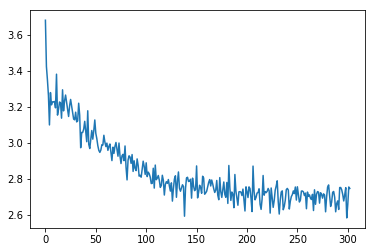

In [61]:
plt.plot(train_class.train_loss_history)
plt.show()

In [0]:
test = torch.tensor(list_data[199][:20], dtype=torch.float32)

In [0]:
first_latent = torch.normal(torch.zeros(64), torch.ones(64))
first_latent /= latent.norm()

second_latent = torch.normal(torch.zeros(64), torch.ones(64))
second_latent /= latent.norm()

lats = []

for i in range(11):
    lats.append(first_latent + (i / 10) * (second_latent - first_latent))
    lats[-1] /= lats[-1].norm()

    
notes = []
for i in range(11):
    fragment = model.decode(lats[i].cuda().view(1, -1), 10)
    part = sample_notes(fragment.view(-1, 128))
    
    notes.append(part)
 
notes = np.concatenate(notes, axis=0)
write_midi(notes, fs=10)

In [0]:
model.eval()

latent = torch.normal(torch.zeros(64), torch.ones(64))
latent /= latent.norm()

fragment, _, _ = model(test.view(1, 20, 128).cuda())

In [0]:
notes = sample_notes(fragment.view(-1, 128))

In [0]:
write_midi(notes, fs=10)

In [63]:
list_data[188].shape

(50, 128)

In [42]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit([list(range(128))])

MultiLabelBinarizer(classes=None, sparse_output=False)

In [0]:
def sample_notes(probs):
  
    notes_numerical = torch.multinomial(probs, 2)
    notes_numerical = notes_numerical.cpu().numpy()
    notes_numerical = [tuple(pitch) for pitch in notes_numerical]

    notes_n_hot = mlb.transform(notes_numerical)
    
    return notes_n_hot

In [0]:
def write_midi(notes, midi_file_name = "result.mid", fs=20):
    
    generate_to_midi = piano_roll_to_pretty_midi(notes.transpose(), fs=fs)
    for note in generate_to_midi.instruments[0].notes:
        note.velocity = 100
    generate_to_midi.write(midi_file_name)

In [0]:
def generate_from_random(unique_notes, batch_size, seq_len=50):
    random_notes = [[x] for x in np.random.choice(128, 50)]
    random_notes = mlb.transform(random_notes)
    return torch.LongTensor(random_notes).view(1, random_notes.shape[0], random_notes.shape[1]).cuda()

def generate_from_constant(unique_notes, batch_size, seq_len=50, note=64):
    random_notes = [[seq_len] for _ in range(seq_len)]
    random_notes = mlb.transform(random_notes)
    return torch.LongTensor(random_notes).view(1, random_notes.shape[0], random_notes.shape[1]).cuda()
  
def generate_notes(previous_notes, model, batch_size, unique_notes, max_generated=1000, seq_len=50, threshold=0.015):
    for n_step in range(max_generated - seq_len):
        prev_notes_truncated = previous_notes[:, -seq_len:, :].float()
        next_notes_probs, _ = model(prev_notes_truncated.cuda())
#         next_notes_probs, _ = model(prev_notes_truncated)
#         new_notes = torch.arange(128)[next_notes_probs[0] > threshold]
        new_notes = torch.multinomial(next_notes_probs, 2)
#         print(new_notes)
        new_notes = list(new_notes.cpu().numpy()[0])
#         print(new_notes)
        
#         print(new_notes)
        new_note_vector = mlb.transform([new_notes])  # WRONG INDEXES!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#         print(new_note_vector)
        new_note_vector = torch.LongTensor(new_note_vector).view(1, new_note_vector.shape[0], new_note_vector.shape[1]).cuda()
#         for note, note_prob in enumerate(next_notes_probs):
#             if np.random.uniform() < note_prob:
#                 next_notes.append(note)
        
#         NEW_NOTE = torch.multinomial(next_notes_probs, 1)
# #         print(NEW_NOTE)
# #         print(previous_notes)
#         previous_notes = torch.cat([previous_notes[:, :], NEW_NOTE], dim=1, out=previous_notes)
        previous_notes = torch.cat([previous_notes[:, :, :], new_note_vector], dim=1)
        
    
    return previous_notes

def write_midi_file_from_generated(generate, midi_file_name = "result.mid", start_index=49, fs=20, max_generated=1000):
    array_piano_roll = np.zeros((128, max_generated), dtype=np.int16)
    
    for index, notes in enumerate(generate[:, :]):
#         print(notes)
        nonzero_notes = np.nonzero(notes)
        if len(nonzero_notes) > 0:
#             print(nonzero_notes)
            nonzero_notes = nonzero_notes[0]
        else:
            continue

        for j in nonzero_notes:
#             print(f'j = {j}, index = {index}')
            array_piano_roll[int(j),index] = 1
#     print(array_piano_roll.sum())
    generate_to_midi = piano_roll_to_pretty_midi(array_piano_roll, fs=fs)
    for note in generate_to_midi.instruments[0].notes:
        note.velocity = 100
    generate_to_midi.write(midi_file_name)
    
    return array_piano_roll

def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm